In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

from scipy.stats import probplot
from sklearn import metrics
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [2]:
def build_model(columns, target_column, model, model_name, df):
  selected_df = df[columns]

  X = selected_df.drop(target_column, axis=1)  # Features
  y = selected_df[target_column]  # Target variable

  numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns
  categorical_cols = X.select_dtypes(include=['object']).columns
  X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
  all_feature_names = list(numerical_cols) + list(X.columns)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 42

  model.fit(X_train, y_train)

  y_pred_train = model.predict(X_train)
  y_pred_test = model.predict(X_test)

  calculate_metrics(model_name, y_train, y_pred_train, y_test, y_pred_test)

  print()
  print()
  return X, y_train, y_pred_train, y_test, y_pred_test

def calculate_metrics(model, y_train, y_pred_train, y_test, y_pred_test):
    # Evaluate the model
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_train = r2_score(y_train, y_pred_train)
    print(model + " Training Set MSE: ", mse_train)
    print(model + " Training Set R2: ", r2_train)

    mse_test = mean_squared_error(y_test, y_pred_test)
    r2_test = r2_score(y_test, y_pred_test)
    print(model + " Testing Set MSE: ", mse_test)
    print(model + " Testing Set R2: ", r2_test)

    errors = abs(y_pred_train - y_train)
    mape = 100 * np.mean(errors / y_train)
    accuracy = 100 - mape
    print('Average Error on trainin: {:0.4f} on training.'.format(np.mean(errors)))
    print('Accuracy on training = {:0.2f}%.'.format(accuracy))
    test_errors = abs(y_pred_test - y_test)
    test_mape = 100 * np.mean(test_errors / y_test)
    test_accuracy = 100 - test_mape
    print('Average Error on testing: {:0.4f} .'.format(np.mean(test_errors)))
    print('Accuracy on testing = {:0.2f}%.'.format(test_accuracy))
    record = [model, mse_train, mse_test, r2_train, r2_test, np.mean(errors), np.mean(test_errors), accuracy, test_accuracy]
    return record

def plot_scatter(y_train, y_pred_train, y_test, y_pred_test, model_name):
    fig, axs = plt.subplots(3, 2, figsize=(8, 12))

    axs[0, 0].scatter(y_train, y_pred_train)
    axs[0, 0].set_xlabel('True Values')
    axs[0, 0].set_ylabel('Predictions')
    axs[0, 0].set_title('Training')
    axs[0, 0].plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--')  # 45-degree red line


    axs[0, 1].scatter(y_test, y_pred_test)
    axs[0, 1].set_xlabel('True Values')
    axs[0, 1].set_ylabel('Predictions')
    axs[0, 1].set_title('Testing')
    axs[0, 1].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # 45-degree red line


    residuals = y_train - y_pred_train
    axs[1, 0].scatter(y_pred_train, residuals)
    axs[1, 0].set_xlabel('Predicted Values')
    axs[1, 0].set_ylabel('Residuals')
    axs[1, 0].axhline(y=0, color='red', linestyle='--')  # Add a horizontal line at y=0
    axs[1, 0].set_title('Residual Training')
    probplot(residuals, plot=axs[2, 0], fit=True, rvalue=True)
    axs[2, 0].set_title('Normal Q-Q Plot for Training Residuals')

    residuals = y_test - y_pred_test
    axs[1, 1].scatter(y_pred_test, residuals)
    axs[1, 1].set_xlabel('Predicted Values')
    axs[1, 1].set_ylabel('Residuals')
    axs[1, 1].axhline(y=0, color='red', linestyle='--')  # Add a horizontal line at y=0
    axs[1, 1].set_title('Residual Testing')
    probplot(residuals, plot=axs[2, 1], fit=True, rvalue=True)
    axs[2, 1].set_title('Normal Q-Q Plot for Testing Residuals')
    # Adjust layout to prevent clipping

    fig.suptitle(model_name, fontsize=16)
    plt.tight_layout()

    plt.show()

# **NOTE**

In order to load the file from google drive, you need mount the drive, and possibly grant access to GoogleColab to read the file. Also you need add shortcut for three files to your google drive root directory, like below picture.

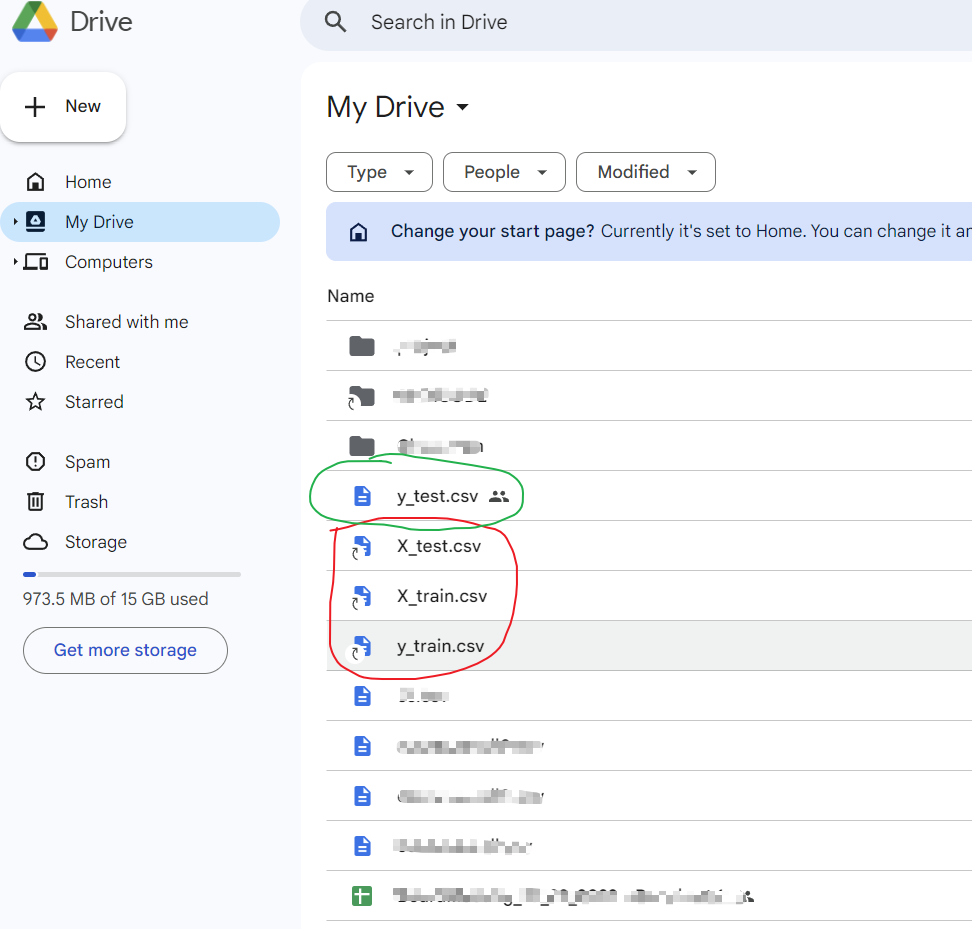




In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# The Workflow

- Question or problem definition.
- Acquire training and testing data.
- Wrangle, prepare, cleanse the data.
- Analyze, identify patterns, and explore the data.
- Model, predict and solve the problem.
- Visualize, report, and present the problem solving steps and final solution.
- Supply or submit the results.

# Question or problem definition
We are working on a supervised, regression machine learning task where the goal is to predict "College Happiness Score". As prospective students navigate their higher education options, understanding the value and satisfaction a college provides is crucial. Leveraging data from the various data source, we will create models to gauge university life quality using any subset of combination of features provided in the dataset.

# Acquire training and testing data

In [4]:
X_train_file = '/content/drive/My Drive/X_train.csv'
df = pd.read_csv(X_train_file)
df = df.rename(columns={'Unnamed: 0':'Id'})

y_train_file = '/content/drive/My Drive/y_train.csv'
df_y = pd.read_csv(y_train_file)
df_y = df_y.rename(columns={'Unnamed: 0':'Id'})

df = pd.merge(df, df_y, on='Id')
df.head(5)

,Id,ADMrate,Ownership,Citytype,SAT,AvgCost,Major_agriculture,Major_NatureResource,Major_Architecture,Major_CS,...,Major_Business,Major_History,Earn,CrimeRate,ACT,Enrollment,FBI.TotalCrime,FBI.CrimeRate,Application.Deadline,HappyScore
0,45,0.3072,Private nonprofit,Town,1317.0,61060.0,0,1,0,1,...,1,1,63800,314.1,30.0,3528.0,176,5.47,15-Jan-19,49.98
1,8,0.2391,Private nonprofit,City,NaN,62849.0,0,1,0,1,...,0,1,46500,236.9,NaN,2907.0,1580,3.37,1-Jan-19,57.04
2,55,0.1425,Private nonprofit,Suburb,1500.0,63860.0,0,0,0,1,...,0,0,82100,396.1,34.0,802.0,10598,6.86,1-Jan-19,59.96
3,209,0.3806,Public,City,1130.0,14824.0,0,1,1,1,...,1,1,42200,381.8,NaN,12175.0,359896,4.21,1-Feb-19,52.54
4,40,0.3224,Public,City,1380.0,26143.0,0,1,1,1,...,1,1,65800,427.3,31.0,28217.0,5184,4.37,1-Feb-19,44.17


## Analyze by describing data

In [5]:
print('The shape of the dataframe: ', df.shape)
df.dtypes

The shape of the dataframe:  (182, 26)


Id                        int64
ADMrate                 float64
Ownership                object
Citytype                 object
SAT                     float64
AvgCost                 float64
Major_agriculture         int64
Major_NatureResource      int64
Major_Architecture        int64
Major_CS                  int64
Major_Edu                 int64
Major_Engineering         int64
Major_Bio                 int64
Major_MathStat            int64
Major_Psychology          int64
Major_SocialScience       int64
Major_Business            int64
Major_History             int64
Earn                     object
CrimeRate               float64
ACT                     float64
Enrollment              float64
FBI.TotalCrime            int64
FBI.CrimeRate           float64
Application.Deadline     object
HappyScore              float64
dtype: object

### Which features contain blank, null or empty values?

The below code shows:
ADMrate, AvgCost have a few null, and SAT and ACT has around 40 null values.

In [6]:
null_counts = pd.DataFrame({
    'Column Name': df.columns,
    'Count of Null': df.isnull().sum(),
    'Percent of Null': (df.isnull().mean() * 100).map('{:.2f}%'.format)
})

# Display the result
null_counts = null_counts[null_counts['Count of Null'] > 0]
print(null_counts)
print()
numerical_cols = df.select_dtypes(include=['number']).columns
categorical_cols = df.select_dtypes(include=['object']).columns
print("Numerical  Columns: ", numerical_cols.values)
print("Categorical Columns: ", categorical_cols.values)
print()
df.describe()

        Column Name  Count of Null Percent of Null
ADMrate     ADMrate              3           1.65%
SAT             SAT             39          21.43%
AvgCost     AvgCost              2           1.10%
ACT             ACT             43          23.63%

Numerical  Columns:  ['Id' 'ADMrate' 'SAT' 'AvgCost' 'Major_agriculture' 'Major_NatureResource'
 'Major_Architecture' 'Major_CS' 'Major_Edu' 'Major_Engineering'
 'Major_Bio' 'Major_MathStat' 'Major_Psychology' 'Major_SocialScience'
 'Major_Business' 'Major_History' 'CrimeRate' 'ACT' 'Enrollment'
 'FBI.TotalCrime' 'FBI.CrimeRate' 'HappyScore']
Categorical Columns:  ['Ownership' 'Citytype' 'Earn' 'Application.Deadline']



,Id,ADMrate,SAT,AvgCost,Major_agriculture,Major_NatureResource,Major_Architecture,Major_CS,Major_Edu,Major_Engineering,...,Major_Psychology,Major_SocialScience,Major_Business,Major_History,CrimeRate,ACT,Enrollment,FBI.TotalCrime,FBI.CrimeRate,HappyScore
count,182.000000,179.000000,143.000000,180.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,...,182.000000,182.000000,182.000000,182.000000,182.000000,139.000000,182.000000,182.000000,182.000000,182.000000
mean,137.049451,45.244647,1259.615385,47790.750000,0.109890,0.675824,0.263736,0.934066,0.626374,0.549451,...,0.917582,0.961538,0.780220,0.917582,363.606593,28.359712,7375.994505,39172.340659,7.175989,53.150330
std,79.756139,598.507942,125.532888,14581.305623,0.330763,0.469357,0.441874,0.358086,0.507368,0.509875,...,0.295114,0.265209,0.542191,0.295114,160.661838,3.033645,8517.279056,77500.352672,3.511761,6.555281
min,0.000000,0.050900,1002.000000,11139.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,99.300000,22.000000,365.000000,74.000000,0.880000,34.150000
25%,68.250000,0.331550,1156.500000,37930.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,284.900000,26.000000,1854.000000,1591.000000,4.405000,49.980000
50%,130.500000,0.552100,1239.000000,52460.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,370.000000,28.000000,3528.500000,8062.000000,6.860000,52.570000
75%,206.250000,0.706350,1363.000000,59633.750000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,396.100000,31.000000,8396.500000,37763.500000,9.235000,57.705000
max,271.000000,8008.000000,1545.000000,64988.000000,2.000000,1.000000,1.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,1244.400000,35.000000,38395.000000,359896.000000,20.370000,71.020000


### ADMrate

There is an outlier for ADMrate which indicates an error in the training data. I am setting this value to the mean of ADMrate, and set Ownership for this record to Public, and Citytype to city.

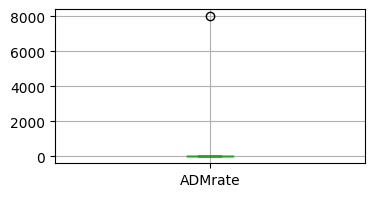

Avg ADMrate before cleanup:  45.244646927374305
Avg ADMrate after cleanup:  0.5100662921348315


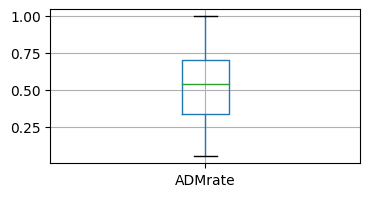

In [7]:
column_name = 'ADMrate'
plt.figure(figsize=(4,2))
df.boxplot(column=column_name)
plt.show()

column_name = 'ADMrate'
avg_admrate = df[column_name].mean()
print('Avg ADMrate before cleanup: ', avg_admrate)
max_value_index = df[column_name].idxmax()
df_excluded = df.drop(max_value_index)
avg_admrate = df_excluded[column_name].mean()
df.loc[df[column_name] > 8000, 'Ownership'] = 'Public'
df.loc[df[column_name] > 8000, 'Citytype'] = 'City'

df.loc[df[column_name] > 8000, column_name] = avg_admrate
avg_admrate = df[column_name].mean()
print('Avg ADMrate after cleanup: ', avg_admrate)
df[column_name].fillna(avg_admrate, inplace=True)

plt.figure(figsize=(4,2))
df.boxplot(column=column_name)
plt.show()

### AvgCost
AvgCost has 2 null values, set them to mean.

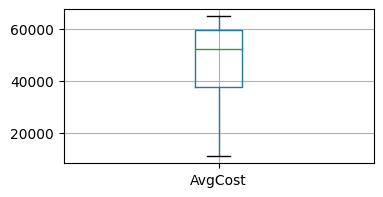

In [8]:
column_name = 'AvgCost'
plt.figure(figsize=(4,2))
df.boxplot(column=column_name)
plt.show()
avg_cost = df['AvgCost'].mean()
df['AvgCost'].fillna(avg_cost, inplace=True)

## Analyze, identify patterns, and explore the data.

### SAT and ACT
Nearly one fourth of the data are null in SAT and ACT. There are two options: set value to 0, or set value to mean value. In LinearRegression, both options will be tried. In tree based methods, like XGBoost and RandomForest, the value will be set to 0.

### Crime Rate
There are three columns related to crime. I evaluate the correlation for all the columns and the correlation between each feature with HappyScore.

In [9]:
column_names = numerical_cols.values.tolist()
column_names.remove('Id')

column_names = [s for s in column_names if 'Major_' not in s]

column2 = 'HappyScore'
corrs = []
for i in range(len(column_names)):
    column1 = column_names[i]

    correlation = df[column1].corr(df[column2])
    corrs.append((column1, column2, correlation, abs(correlation)))
    #print(f'Correlation between {column1} and {column2}: {correlation}')

print()
corrs_sorted = sorted(corrs, key=lambda x: x[3], )

corrs_sorted = corrs_sorted[0:-1]
corrs_df = pd.DataFrame(corrs_sorted, columns=['Feature', '1', 'Score', '2'])
corrs_df[['Feature', 'Score']][::-1]


,Feature,Score
7,FBI.CrimeRate,-0.236449
6,Enrollment,0.136631
5,ADMrate,-0.111047
4,CrimeRate,-0.104876
3,ACT,0.093221
2,SAT,0.084220
1,FBI.TotalCrime,0.036781
0,AvgCost,0.006289


### Earn
There is one error for earn, fix it by setting to mean value.

In [10]:
df_excluded = df[df['Earn'] != 'PrivacySuppressed']
df_excluded['Earn'] = pd.to_numeric(df['Earn'], errors='coerce')

avg_earn = df_excluded['Earn'].mean()
df.loc[df['Earn'] == 'PrivacySuppressed', 'Earn'] = avg_earn
df['Earn'] = pd.to_numeric(df['Earn'], errors='coerce')

<ipython-input-10-24c44609904d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_excluded['Earn'] = pd.to_numeric(df['Earn'], errors='coerce')


## Happy Score Analysis

<Figure size 400x200 with 0 Axes>

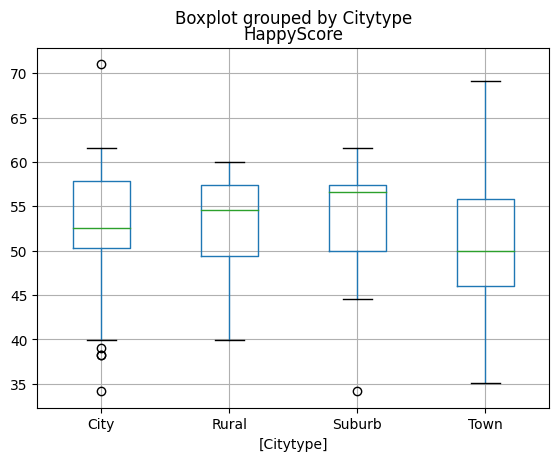

In [11]:
plt.figure(figsize=(4, 2))
df.boxplot(column=['HappyScore'], by=['Citytype'])
plt.show()

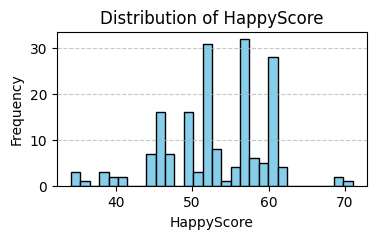

In [12]:
column_name = 'HappyScore'
plt.figure(figsize=(4, 2))
plt.hist(df[column_name], bins=30, color='skyblue', edgecolor='black')
plt.title(f'Distribution of {column_name}')
plt.xlabel(column_name)
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

### Final Check

In [13]:
null_counts = pd.DataFrame({
    'Column Name': df.columns,
    'Count of Null': df.isnull().sum(),
    'Percent of Null': (df.isnull().mean() * 100).map('{:.2f}%'.format)
})

# Display the result
null_counts = null_counts[null_counts['Count of Null'] > 0]
null_counts

,Column Name,Count of Null,Percent of Null
SAT,SAT,39,21.43%
ACT,ACT,43,23.63%


## Model, predict and solve the problem.

### Feature Selection
Correlation analysis can reveal meaningful relationships between different metrics or groups of metrics. Removing highly correlated features is a crucial preprocessing step in machine learning to improve model performance, interpretability, generalization, and computational efficiency. It helps create more robust and efficient models that are better suited for real-world applications. Since we have only 18 numerical features, and we calculate correction for each pair and we notice SAT and ACT have 0.99 correlated score (totally understandable, students get good score in one test always achieve high score in another.) Not super suppuringsly, standard tests are negatively correlated to ADMrate, meaning, the college with more advanced students has lower admission rate, indicating how competitive the schools are. There are three columns related to crime: CrimeRate, FBI.CrimeRate and FBI.TotalCrime. But suppuringsly, they are not strongly correlated.




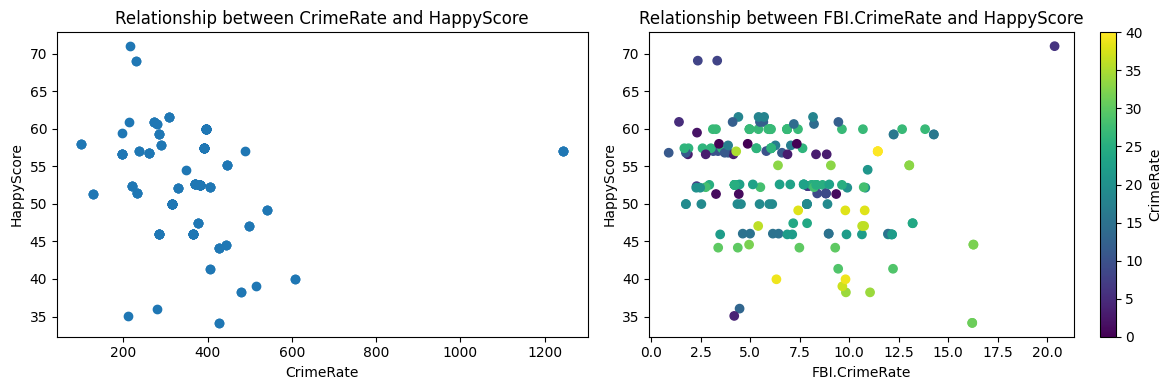

In [14]:
col1 = 'CrimeRate'
col2 = 'HappyScore'

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].scatter(df[col1], df[col2])
axes[0].set_xlabel(col1)
axes[0].set_ylabel(col2)
axes[0].set_title(f'Relationship between {col1} and {col2}')

col1 = 'FBI.CrimeRate'
col2 = 'HappyScore'
c_col = 'CrimeRate'
df['color_feature_numerical'] = df[c_col].astype('category').cat.codes

scatter = axes[1].scatter(df[col1], df[col2], c=df['color_feature_numerical'], cmap='viridis')
axes[1].set_xlabel(col1)
axes[1].set_ylabel(col2)
axes[1].set_title(f'Relationship between {col1} and {col2}')
cbar = plt.colorbar(scatter, ax=axes[1])
cbar.set_label(c_col)
plt.tight_layout()
plt.show()

As we observed from above data exploration, we first include Crime Rate in our feature list, and  remove other two crime related features. We try various combinations (more than 1000) to include enrollment rate, citytype, SAT, ADMrate, AvgCost, Earn and all the majors, and run three different models, with parameter turnings, for example, we use lasso regression (instead of pure linear regression), we set different max depth and number of trees in both xgboost and random forest. The main parameter that has shown the most impact for training set performance are min samples leaf, number of estimators, max depth of tree. Parameter tuning using cross validation tends to choose the smaller end of the parameters.We use GridSearchCV and RandomSearch, and record the MSE and R2 for each run and observe that MSE or R2 value decreased when we introduced more features in our training data set. Below table shows some of the features we selected with parameter turing. We try Linear Regression, RandomForest and XGBoost methods.

1. Linear Regression
2. XGBoost
3. Random Forest

X_train.csv are split into two parts, the training data set (80%) and the testing data set (20%). The training data set is fit into the model, and the testing data are used to evaluate the model performance.

### Linear Regression
Linear regression analysis is used to predict the value of a variable based on the value of another variable, in our case, use the variables provided in the data set, including college enrollments, city type, major, SAT score and crime rate, to predict the happiness of students. While one of the main advantages of using linear regression is that it is easy to understand and interpret, it is also, sensitive to the outliers and noises, and more important, it is not suitable to identify non-linear relationships among variables. However, we still can leverage linear regression to find out the importance of the features: the magnitude of the coefficients represents the relative importance of the features.

First, I include all the features.

In [15]:
target_column = 'HappyScore'
columns = ['ADMrate', 'Ownership', 'Citytype', 'SAT', 'AvgCost',
       'Major_agriculture', 'Major_NatureResource', 'Major_Architecture',
       'Major_CS', 'Major_Edu', 'Major_Engineering', 'Major_Bio',
       'Major_MathStat', 'Major_Psychology', 'Major_SocialScience',
       'Major_Business', 'Major_History', 'Earn', 'CrimeRate',
       'Enrollment', 'FBI.TotalCrime', 'FBI.CrimeRate', 'HappyScore']

model = LinearRegression()
model_name = 'Linear Regression All Features With Average ACT/SAT'

df_copy = df.copy()
column_name = 'SAT'
avg_value = df_copy[column_name].mean()
df_copy['SAT'].fillna(avg_value, inplace=True)

column_name = 'ACT'
avg_value = df_copy[column_name].mean()
df_copy['ACT'].fillna(avg_value, inplace=True)

X, y_train, y_pred_train, y_test, y_pred_test = build_model(columns, target_column, model, model_name, df_copy)

Linear Regression All Features With Average ACT/SAT Training Set MSE:  34.79631259168532
Linear Regression All Features With Average ACT/SAT Training Set R2:  0.23241859469120418
Linear Regression All Features With Average ACT/SAT Testing Set MSE:  37.048668364587165
Linear Regression All Features With Average ACT/SAT Testing Set R2:  -0.16283583169608074
Average Error on trainin: 4.5555 on training.
Accuracy on training = 91.08%.
Average Error on testing: 4.7451 .
Accuracy on testing = 90.72%.




In [16]:
df_copy = df.copy()
sat_act_fill = 0
df_copy['SAT'].fillna(sat_act_fill, inplace=True)
df_copy['ACT'].fillna(sat_act_fill, inplace=True)
model = LinearRegression()
model_name = 'Linear Regression All Features With Zero ACT/SAT'
X, y_train, y_pred_train, y_test, y_pred_test = build_model(columns, target_column, model, model_name, df_copy)

Linear Regression All Features With Zero ACT/SAT Training Set MSE:  34.55515852626108
Linear Regression All Features With Zero ACT/SAT Training Set R2:  0.23773827837741457
Linear Regression All Features With Zero ACT/SAT Testing Set MSE:  38.812846361988235
Linear Regression All Features With Zero ACT/SAT Testing Set R2:  -0.21820757592936801
Average Error on trainin: 4.4902 on training.
Accuracy on training = 91.20%.
Average Error on testing: 4.8203 .
Accuracy on testing = 90.57%.




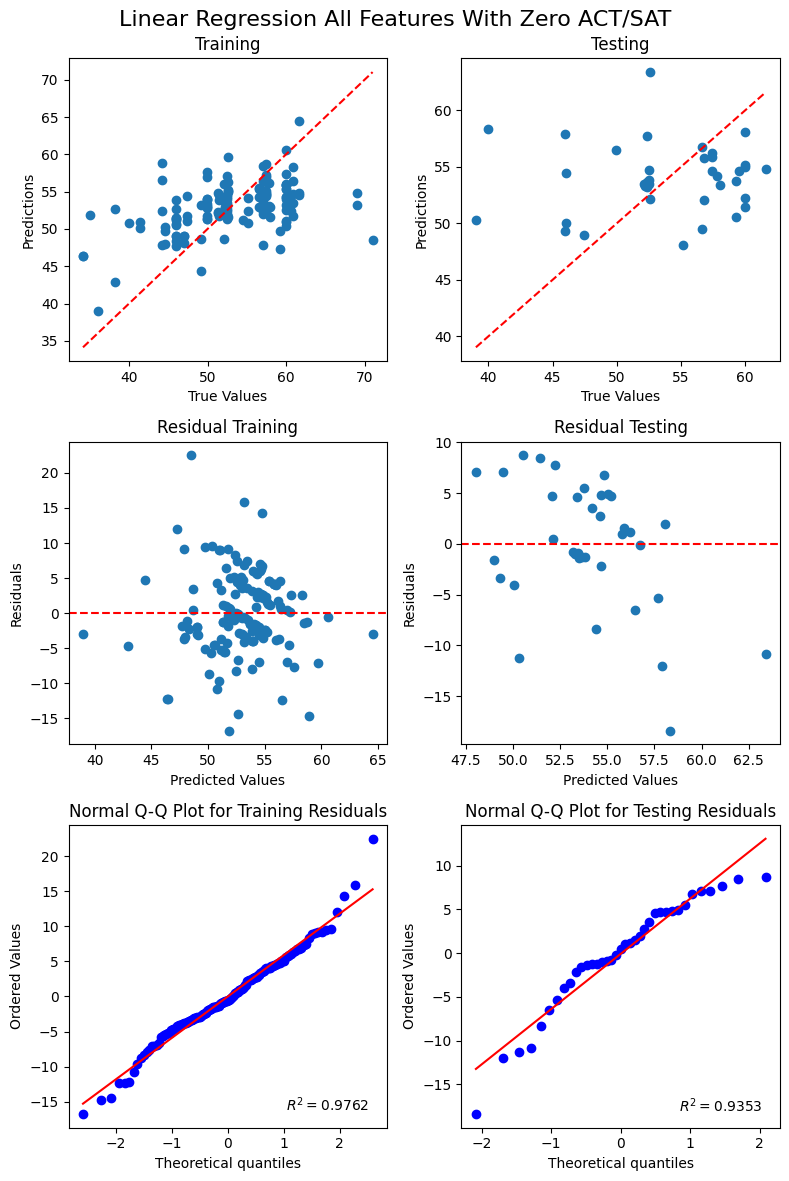

In [17]:
plot_scatter(y_train, y_pred_train, y_test, y_pred_test, model_name)

Many models are trained, each of them has different feature sets. unfortunately, linear regression does not show convincing results on both training data set and testing data. It is because there is no obvious linear relationship between features and Happy Score. I did not include all the models here. The way I did is to numerate all the subset of a small feature sets, and feed each subset into the model train, and store the results, and then compare MSE and R2 on the testing data set.

### XGBoost

Tree based supervised machine learning methods, like XGBoost, which stands for Extreme Gradient Boosting, and Random Forest, are also often used for their ability to handle complex relationships in data, provide robust predictions, and effectively deal with both classification and regression tasks. These algorithms have gained popularity due to their ensemble approach, mitigating overfitting, and incorporating features like feature importance analysis, making them valuable tools in the field of machine learning.

#### XGBRegressor All Features with Default Parameter
The results below show overfitting on training data set with ZERO MSE!

In [18]:
target_column = 'HappyScore'
columns = ['ADMrate', 'Ownership', 'Citytype', 'SAT', 'AvgCost',
       'Major_agriculture', 'Major_NatureResource', 'Major_Architecture',
       'Major_CS', 'Major_Edu', 'Major_Engineering', 'Major_Bio',
       'Major_MathStat', 'Major_Psychology', 'Major_SocialScience',
       'Major_Business', 'Major_History', 'Earn', 'CrimeRate',
       'Enrollment', 'FBI.TotalCrime', 'FBI.CrimeRate', 'HappyScore']

model = XGBRegressor()
model_name = 'XGBRegressor All Features with Default Parameters'

sat_act_fill = 0
df['SAT'].fillna(sat_act_fill, inplace=True)
df['ACT'].fillna(sat_act_fill, inplace=True)

X, y_train, y_pred_train, y_test, y_pred_test = build_model(columns, target_column, model, model_name, df)

feature_importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df.head(5)

XGBRegressor All Features with Default Parameters Training Set MSE:  1.0178551246445729e-06
XGBRegressor All Features with Default Parameters Training Set R2:  0.9999999775468545
XGBRegressor All Features with Default Parameters Testing Set MSE:  13.611686574516163
XGBRegressor All Features with Default Parameters Testing Set R2:  0.5727739328468506
Average Error on trainin: 0.0007 on training.
Accuracy on training = 100.00%.
Average Error on testing: 2.7229 .
Accuracy on testing = 94.61%.




,Feature,Importance
9,Major_Bio,0.283785
16,CrimeRate,0.256309
24,Citytype_Town,0.130284
18,FBI.TotalCrime,0.112679
17,Enrollment,0.058438


#### XGBRegressor All Features with RandomizedSearchCV

In [19]:
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'n_estimators': [50, 100, 200, 300],
    # Add other hyperparameters as needed
}
model = XGBRegressor()
model_name = 'XGBRegressor All Features with RandomizedSearchCV'

# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=10, scoring='neg_mean_squared_error', cv=3, verbose=1, n_jobs=-1)

X, y_train, y_pred_train, y_test, y_pred_test = build_model(columns, target_column, random_search, model_name, df)
random_search.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
XGBRegressor All Features with RandomizedSearchCV Training Set MSE:  3.181968657275734
XGBRegressor All Features with RandomizedSearchCV Training Set R2:  0.929808080463564
XGBRegressor All Features with RandomizedSearchCV Testing Set MSE:  13.549141927883248
XGBRegressor All Features with RandomizedSearchCV Testing Set R2:  0.574737003569658
Average Error on trainin: 1.3060 on training.
Accuracy on training = 97.37%.
Average Error on testing: 2.6161 .
Accuracy on testing = 94.80%.




{'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.01}

#### XGBRegressor All Features with GridSearchCV

In [20]:
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'n_estimators': [50, 100, 200],
    # Add other hyperparameters as needed
}
model = XGBRegressor()
model_name = 'XGBRegressor All Features with GridSearchCV'

# Instantiate the grid search model
grid_search = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)

X, y_train, y_pred_train, y_test, y_pred_test = build_model(columns, target_column, grid_search, model_name, df)
grid_search.best_params_

Fitting 5 folds for each of 45 candidates, totalling 225 fits
XGBRegressor All Features with GridSearchCV Training Set MSE:  4.56737675743021
XGBRegressor All Features with GridSearchCV Training Set R2:  0.89924698311623
XGBRegressor All Features with GridSearchCV Testing Set MSE:  12.720943632263113
XGBRegressor All Features with GridSearchCV Testing Set R2:  0.6007314237852373
Average Error on trainin: 1.5302 on training.
Accuracy on training = 96.94%.
Average Error on testing: 2.5362 .
Accuracy on testing = 94.93%.




{'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}

#### XGBRegressor Minumum Features with Default Parameter




XGBRegressor Minimum Features with Default Parameters Training Set MSE:  3.280646141201895e-06
XGBRegressor Minimum Features with Default Parameters Training Set R2:  0.9999999276313267
XGBRegressor Minimum Features with Default Parameters Testing Set MSE:  3.551220941083843
XGBRegressor Minimum Features with Default Parameters Testing Set R2:  0.8885388560818309
Average Error on trainin: 0.0010 on training.
Accuracy on training = 100.00%.
Average Error on testing: 0.4393 .
Accuracy on testing = 99.07%.




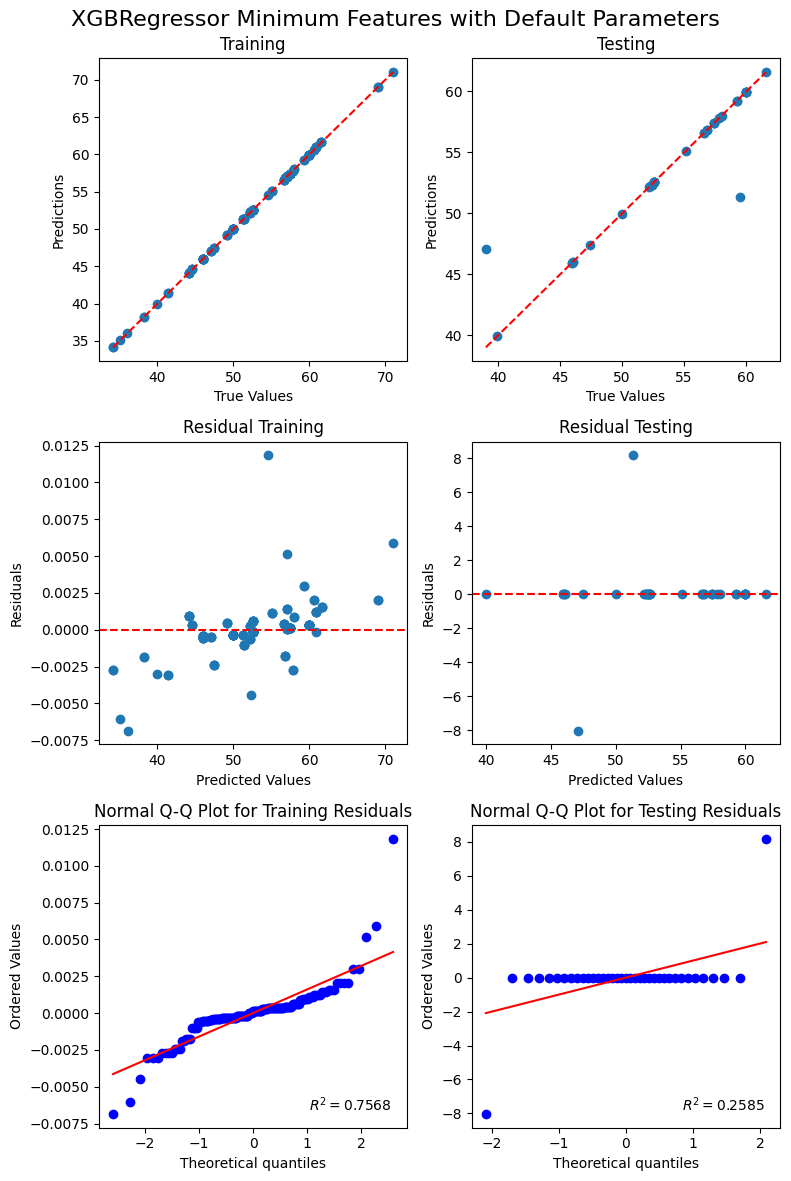

In [21]:
target_column = 'HappyScore'
columns = ['CrimeRate', 'HappyScore']

model = XGBRegressor()
model_name = 'XGBRegressor Minimum Features with Default Parameters'

X, y_train, y_pred_train, y_test, y_pred_test = build_model(columns, target_column, model, model_name, df)

plot_scatter(y_train, y_pred_train, y_test, y_pred_test, model_name)

In [22]:
target_column = 'HappyScore'
columns = ['CrimeRate', 'ADMrate', 'HappyScore']

model = XGBRegressor()
model_name = 'XGBRegressor Minimum Features with Default Parameters'

X, y_train, y_pred_train, y_test, y_pred_test = build_model(columns, target_column, model, model_name, df)

XGBRegressor Minimum Features with Default Parameters Training Set MSE:  2.7272681691205233e-05
XGBRegressor Minimum Features with Default Parameters Training Set R2:  0.9999993983844327
XGBRegressor Minimum Features with Default Parameters Testing Set MSE:  21.040415557841676
XGBRegressor Minimum Features with Default Parameters Testing Set R2:  0.339610566197293
Average Error on trainin: 0.0036 on training.
Accuracy on training = 99.99%.
Average Error on testing: 1.8315 .
Accuracy on testing = 96.27%.




In [23]:
target_column = 'HappyScore'
columns = ['CrimeRate', 'Enrollment', 'HappyScore']

model = XGBRegressor()
model_name = 'XGBRegressor Minimum Features with Default Parameters'

X, y_train, y_pred_train, y_test, y_pred_test = build_model(columns, target_column, model, model_name, df)

XGBRegressor Minimum Features with Default Parameters Training Set MSE:  1.3788765169488977e-05
XGBRegressor Minimum Features with Default Parameters Training Set R2:  0.9999996958298464
XGBRegressor Minimum Features with Default Parameters Testing Set MSE:  20.131280546561815
XGBRegressor Minimum Features with Default Parameters Testing Set R2:  0.3681453236833715
Average Error on trainin: 0.0027 on training.
Accuracy on training = 99.99%.
Average Error on testing: 2.4035 .
Accuracy on testing = 95.29%.




In [24]:
target_column = 'HappyScore'
columns = ['CrimeRate', 'Citytype', 'Major_Bio', 'SAT', 'HappyScore']
model = XGBRegressor()
model_name = 'XGBRegressor Minimum Features with Default Parameters'

X, y_train, y_pred_train, y_test, y_pred_test = build_model(columns, target_column, model, model_name, df)

XGBRegressor Minimum Features with Default Parameters Training Set MSE:  5.977797641274583e-05
XGBRegressor Minimum Features with Default Parameters Training Set R2:  0.9999986813412192
XGBRegressor Minimum Features with Default Parameters Testing Set MSE:  18.217712339260867
XGBRegressor Minimum Features with Default Parameters Testing Set R2:  0.4282059351997327
Average Error on trainin: 0.0058 on training.
Accuracy on training = 99.99%.
Average Error on testing: 2.1319 .
Accuracy on testing = 95.78%.




As we observed from above data exploration, we first include Crime Rate in our feature list, and  remove other two crime related features. We try various combinations (actually more 1000) to include enrollment rate, citytype, SAT, ADMrate, AvgCost, Earn and all the majors, and run three different models, with parameter turnings, for example, we use lasso regression (instead of pure linear regression), we set different max depth and number of trees in both xgboost and random forest. The main parameter that has shown the most impact for training set performance are min samples leaf, number of estimators, max depth of tree. Parameter tuning using cross validation tends to choose the smaller end of the parameters.We use GridSearchCV and RandomSearch, and record the MSE and R2 for each run and observe that MSE or R2 value decreased when we introduced more features in our training data set.

This observation with the above (and many more other, which are not included here) experiments , we believe the CrimeRate is the main source to contribute to happiness score. We then group by crime rate and happy score from the train set and aggregate the count. Surprisingly, the crime rate and happy score follows n to 1 mapping perfectly. For example, if the crime rate is 99.3, then the happy score is 58.01. It is always true for every crime rate. We collect all the distinct crime rates from testing data, and find only two crime rates (total 4 records) not exist in the training set (195.5, 399.9).


### RandomForest
#### RandomForest All Features with Default Parameters


In [25]:
target_column = 'HappyScore'
columns = ['ADMrate', 'Ownership', 'Citytype', 'SAT', 'AvgCost',
       'Major_agriculture', 'Major_NatureResource', 'Major_Architecture',
       'Major_CS', 'Major_Edu', 'Major_Engineering', 'Major_Bio',
       'Major_MathStat', 'Major_Psychology', 'Major_SocialScience',
       'Major_Business', 'Major_History', 'Earn', 'CrimeRate',
       'Enrollment', 'FBI.TotalCrime', 'FBI.CrimeRate', 'HappyScore']

model = RandomForestRegressor(n_estimators=100, max_depth=100, random_state=42)
model_name = 'RandomForest All Features with Default Parameters'

sat_act_fill = 0
df['SAT'].fillna(sat_act_fill, inplace=True)
df['ACT'].fillna(sat_act_fill, inplace=True)

X, y_train, y_pred_train, y_test, y_pred_test = build_model(columns, target_column, model, model_name, df)

feature_importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df.head(5)

RandomForest All Features with Default Parameters Training Set MSE:  3.508945099034436
RandomForest All Features with Default Parameters Training Set R2:  0.9225952174337042
RandomForest All Features with Default Parameters Testing Set MSE:  14.209589772432386
RandomForest All Features with Default Parameters Testing Set R2:  0.5540077182131494
Average Error on trainin: 1.1733 on training.
Accuracy on training = 97.62%.
Average Error on testing: 2.5969 .
Accuracy on testing = 94.76%.




,Feature,Importance
16,CrimeRate,0.466902
18,FBI.TotalCrime,0.128616
19,FBI.CrimeRate,0.101353
2,AvgCost,0.059719
17,Enrollment,0.056351


#### RandomForest All Features with GridSearchCV

To reduce the running time for below code, we eliminate several options in the parameter grid below. It may take couple of minutes depending on the server loading.

In [26]:
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [10,20],
    'max_features': [4, 6, 8],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10],
    'n_estimators': [50, 100]
}
rf = RandomForestRegressor(random_state = 42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                          cv = 5, n_jobs = -1, verbose = 2, return_train_score=True)
model_name = 'RandomForest All Features with GridSearchCV'

sat_act_fill = 0
df['SAT'].fillna(sat_act_fill, inplace=True)
df['ACT'].fillna(sat_act_fill, inplace=True)

X, y_train, y_pred_train, y_test, y_pred_test = build_model(columns, target_column, grid_search, model_name, df)

grid_search.best_params_

Fitting 5 folds for each of 144 candidates, totalling 720 fits
RandomForest All Features with GridSearchCV Training Set MSE:  8.038316751827438
RandomForest All Features with GridSearchCV Training Set R2:  0.8226805655792593
RandomForest All Features with GridSearchCV Testing Set MSE:  17.985530588392326
RandomForest All Features with GridSearchCV Testing Set R2:  0.43549335661847244
Average Error on trainin: 1.9738 on training.
Accuracy on training = 96.04%.
Average Error on testing: 3.4648 .
Accuracy on testing = 93.18%.




{'bootstrap': False,
 'max_depth': 10,
 'max_features': 8,
 'min_samples_leaf': 4,
 'min_samples_split': 8,
 'n_estimators': 100}

#### RandomForest Minumum Features with Default Parameter

In [27]:
target_column = 'HappyScore'
columns = ['CrimeRate', 'HappyScore']

model = RandomForestRegressor(n_estimators=100, max_depth=100, random_state=42)
model_name = 'RandomForest Minumum Features with Default Parameters'

X, y_train, y_pred_train, y_test, y_pred_test = build_model(columns, target_column, model, model_name, df)

RandomForest Minumum Features with Default Parameters Training Set MSE:  2.094087513586177
RandomForest Minumum Features with Default Parameters Training Set R2:  0.9538059490561603
RandomForest Minumum Features with Default Parameters Testing Set MSE:  4.689650944054014
RandomForest Minumum Features with Default Parameters Testing Set R2:  0.8528072830518824
Average Error on trainin: 0.5706 on training.
Accuracy on training = 98.83%.
Average Error on testing: 1.0299 .
Accuracy on testing = 97.88%.




#### RandomForest Minumum Features with GridSearchCV

In [28]:
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [10,20,25],
    'max_features': [4, 6, 8],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10],
    'n_estimators': [50, 100]
}
target_column = 'HappyScore'
columns = ['CrimeRate', 'HappyScore']
rf = RandomForestRegressor(random_state = 42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                          cv = 5, n_jobs = -1, verbose = 2, return_train_score=True)
model_name = 'RandomForest Minimum Features with GridSearchCV'

X, y_train, y_pred_train, y_test, y_pred_test = build_model(columns, target_column, grid_search, model_name, df)

grid_search.best_params_

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
RandomForest Minimum Features with GridSearchCV Training Set MSE:  13.951787441668015
RandomForest Minimum Features with GridSearchCV Training Set R2:  0.6922336933596773
RandomForest Minimum Features with GridSearchCV Testing Set MSE:  14.399095808095606
RandomForest Minimum Features with GridSearchCV Testing Set R2:  0.5480597471167712
Average Error on trainin: 2.2493 on training.
Accuracy on training = 95.39%.
Average Error on testing: 2.5036 .
Accuracy on testing = 95.01%.




{'bootstrap': True,
 'max_depth': 10,
 'max_features': 4,
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'n_estimators': 100}

## Model, predict and solve the problem

Based on the observation of crime rate and happy score mapping, and exhibit10, showing the same color along x axis, and the crime rate in the testing dataset matches the same values in training data set (except 4 records from 90), we will use a simplest mapping method for 86 records, and for the other 4 records, we will apply Random Forest trained from training data set with lowest MSE and highest R2 on testing data set.


In [29]:
crime_happy_dict = df.set_index('CrimeRate')['HappyScore'].to_dict()

# Print the resulting dictionary
print("CrimeRate to HappyScore Dictionary:")
print(crime_happy_dict)

CrimeRate to HappyScore Dictionary:
{314.1: 49.98, 236.9: 57.04, 396.1: 59.96, 381.8: 52.54, 427.3: 44.17, 261.2: 56.82, 284.9: 46.04, 442.9: 44.58, 232.3: 51.4, 365.3: 45.94, 290.3: 57.8, 196.2: 56.61, 219.2: 52.37, 446.1: 55.14, 196.1: 59.5, 309.1: 61.59, 377.3: 47.43, 391.4: 57.42, 229.1: 69.09, 329.5: 52.16, 1244.4: 57.01, 480.1: 38.22, 273.5: 60.92, 540.5: 49.14, 127.8: 51.32, 280.4: 60.65, 514.7: 39.03, 608.4: 39.96, 215.6: 71.02, 370.0: 52.6, 278.5: 36.05, 405.9: 52.23, 285.2: 59.26, 348.6: 54.55, 497.7: 47.06, 427.4: 34.15, 489.1: 57.01, 211.6: 35.08, 406.0: 41.36, 99.3: 58.01, 212.2: 60.93}


In [30]:
X_test_file = '/content/drive/My Drive/X_test.csv'
df_test = pd.read_csv(X_test_file)
df_test = df_test.rename(columns={'Unnamed: 0':'Id'})
df_test

,Id,ADMrate,Ownership,Citytype,SAT,AvgCost,Major_agriculture,Major_NatureResource,Major_Architecture,Major_CS,...,Major_SocialScience,Major_Business,Major_History,Earn,CrimeRate,ACT,Enrollment,FBI.TotalCrime,FBI.CrimeRate,Application.Deadline
0,14,0.0695,Private nonprofit,City,1470.0,64144.0,0,1,1,1,...,1,1,1,92100,381.8,33.0,8100.0,359896,4.21,1-Jan-19
1,109,0.4535,Public,City,1271.0,24551.0,1,1,1,2,...,1,2,1,49900,229.1,28.0,30135.0,43472,10.51,31-Jan-19
2,159,NaN,Public,City,NaN,NaN,0,0,0,0,...,0,0,0,83000,514.7,NaN,911.0,37958,9.65,30-Nov-18
3,162,0.6573,Public,City,1153.0,22601.0,0,0,0,1,...,1,1,1,53100,196.2,26.0,18697.0,2714,5.10,15-Jan-19
4,253,0.5438,Private nonprofit,City,1159.0,47404.0,0,1,0,1,...,1,1,1,43900,405.9,25.0,1272.0,2738,6.79,1-Mar-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,98,0.7739,Private nonprofit,City,1194.0,49150.0,0,1,0,1,...,1,1,1,50000,497.7,27.0,1654.0,5526,14.66,1-Feb-19
86,142,0.4764,Private nonprofit,Town,NaN,59550.0,0,1,0,1,...,1,1,1,47800,381.8,NaN,2282.0,68,1.02,1-Feb-19
87,62,0.1608,Private nonprofit,City,1439.0,61481.0,0,1,0,1,...,1,1,1,73700,446.1,33.0,6039.0,80966,13.03,1-Jan-19
88,203,0.7462,Public,City,NaN,24617.0,1,1,1,1,...,1,1,1,46200,399.9,NaN,32646.0,77314,14.60,1-May-19


In [31]:
def fit_model(df_test):
  target_column = 'HappyScore'
  columns = ['CrimeRate', 'HappyScore']

  selected_df = df[columns]

  X = selected_df.drop(target_column, axis=1)  # Features
  y = selected_df[target_column]  # Target variable

  model = XGBRegressor()
  model_name = 'XGBRegressor Minimum Features with Default Parameters'
  model.fit(X, y)

  return model

In [32]:
columns = ['CrimeRate', 'HappyScore']
target_column = 'HappyScore'

selected_df = df[columns]

X = selected_df.drop(target_column, axis=1)  # Features
y = selected_df[target_column]  # Target variable
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 42

model = fit_model(X)

columns = ['CrimeRate']
target_column = 'HappyScore'
selected_df = df_test[columns]

y_pred_test = model.predict(selected_df)


test_crimerates = df_test['CrimeRate'].values.tolist()
result = []
for t in test_crimerates:
  if t in crime_happy_dict:
    result.append(crime_happy_dict[t])
  else:
    result.append(None)

y_pred_map = np.array(result)
y_pred_map[y_pred_map==None] = y_pred_test[y_pred_map==None]

len(y_pred_map)

90

In [33]:
y_pred_map

array([52.54, 69.09, 39.03, 56.61, 52.23, 59.96, 49.98, 45.94, 56.61,
       49.98, 61.59, 59.5, 57.42, 49.98, 52.16, 57.42, 49.98, 38.22,
       57.42, 60.93, 52.23, 60.92, 44.17, 51.4, 59.96, 49.14, 52.16,
       59.26, 59.96, 52.54, 45.94, 57.42, 58.01, 59.96, 60.65, 49.14,
       52.54, 52.54, 46.04, 59.96, 47.06, 57.42, 52.54, 59.96, 57.42,
       39.96, 57.04, 52.23, 56.82, 51.32, 59.26, 52.54, 57.42, 52.54,
       69.09, 49.98, 59.96, 56.61, 59.26, 49.98, 34.15, 49.98, 57.42,
       59.959815979003906, 39.96, 57.42, 44.17, 52.54, 52.54, 57.8, 59.96,
       52.6, 59.5, 52.23, 69.09, 49.98, 57.04, 52.16, 35.08,
       59.959815979003906, 56.61, 52.23, 59.26, 51.3206672668457, 52.54,
       47.06, 52.54, 55.14, 59.959815979003906, 52.54], dtype=object)

In [38]:
df_test['HappyScore'] = y_pred_map
final_result = df_test[['Id', 'HappyScore']]
final_result.set_index('Id', inplace=True)
final_result
final_result.to_csv('/content/drive/My Drive/y_test.csv')

In [40]:
final_result = final_result.rename(columns={'HappyScore': 'prediction'})

In [43]:
final_result

,prediction
Id,
14,52.54
109,69.09
159,39.03
162,56.61
253,52.23
...,...
98,47.06
142,52.54
62,55.14


In [44]:
final_result
final_result.to_csv('/content/drive/My Drive/richard_feng_16_stmargarets.csv', index=False)
print('done')

done
